**IMPORT LIBRARIES**


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize,rescale

**Importing the Fashion MNIST dataset**

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#Creating Labels for the input
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Preprocessing Data**

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [ ]:
validationX = train_images[54000:,:]
trainX = train_images[:54000,:]

In [ ]:
validationY = train_labels[54000:]
trainY = train_labels[:54000]

In [ ]:
validationX.shape

(6000, 28, 28)

In [ ]:
#VGG16 takes input in RGB so additional dimension is required with 3 channels 
trainX = np.repeat(trainX[..., np.newaxis], 3, -1)
validationX = np.repeat(validationX[...,np.newaxis],3,-1)

In [ ]:
validationX.shape

(6000, 28, 28, 3)

In [ ]:
#Fashion-MNIST Datase has 28x28 images but for VGG16 we need to resize it to atleast 32x32

from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

trainX = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in trainX])
validationX = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in validationX])

# Display the new shape
trainX.shape, validationX.shape

((54000, 32, 32, 3), (6000, 32, 32, 3))

In [ ]:
input_shape = (32,32,3)
batch_size = 64

In [ ]:
# Create the base model of VGG16
vgg16_model = tf.keras.applications.vgg16.VGG16(input_shape = input_shape, include_top=False)

In [ ]:
vgg16_model.input

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
# Making the model sequential
model = tf.keras.Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [ ]:
type(model)

tensorflow.python.keras.engine.sequential.Sequential

In [ ]:
#Freezing all the layers

for layer in model.layers:
    layer.trainable = False

In [ ]:
#Adding dropout and dense layer for 10 nodes of output
#Only these layers will be trained

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

**COMPILE DATA**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**IMAGE GENERATOR**



In [ ]:
#Implementing ImageDataGenerator for making it more robust

gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, height_shift_range=0.08, zoom_range=0.08)

*Google Drive with Colab*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**CHECKPOINTS**

In [ ]:
checkpoint_path = '/content/drive/My Drive/DLT3/cp-{epoch:02d}.ckpt'



cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=1
)

**RELOAD WEIGHTS**

In [ ]:
model.load_weights('/content/drive/My Drive/DLT3/cp-14.ckpt')

**TRAINING MODEL**

In [ ]:
history = model.fit_generator(gen.flow(trainX,trainY,batch_size),
                              steps_per_epoch=trainX.shape[0]//batch_size,
                              epochs=25,
                              validation_data=gen.flow(validationX,validationY,batch_size),
                              validation_steps=validationX.shape[0]//batch_size,
                              callbacks=[cp_callback]
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/25
843/843 [==============================] - 35s 38ms/step - loss: 2.0277 - accuracy: 0.1026 - val_loss: 1.8795 - val_accuracy: 0.1042

Epoch 00001: saving model to /content/drive/My Drive/DLT3/cp-01.ckpt
Epoch 2/25
843/843 [==============================] - 32s 38ms/step - loss: 1.8970 - accuracy: 0.1033 - val_loss: 1.8434 - val_accuracy: 0.1050

Epoch 00002: saving model to /content/drive/My Drive/DLT3/cp-02.ckpt
Epoch 3/25
843/843 [==============================] - 32s 38ms/step - loss: 1.8644 - accuracy: 0.1027 - val_loss: 1.8203 - val_accuracy: 0.1027

Epoch 00003: saving model to /content/drive/My Drive/DLT3/cp-03.ckpt
Epoch 4/25
843/843 [==============================] - 32s 38ms/step - loss: 1.8431 - accuracy: 0.1036 - val_loss: 1.8192 - val_accuracy: 0.1032

Epoch 00004: saving model to /content/drive/My Drive/DLT3/cp-04.ckpt
Epoch 5/25
843/843 [==============================] - 32s 38ms/step - loss: 1.8331 - accuracy: 0.1033 - val_loss: 1.7810 - val_accuracy: 0.1041


**GRAPHS**

**Train Accuracy v/s Epochs**

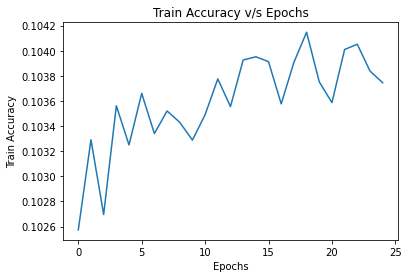

In [ ]:
#Train Accuracy v/s Epochs
plt.plot(history.history['accuracy'])
plt.title('Train Accuracy v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.show()

**Train Loss v/s Epochs**

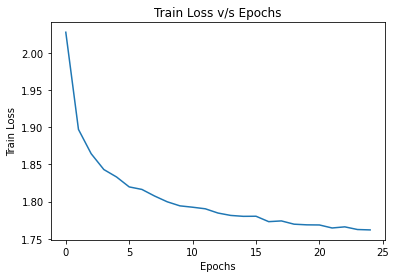

In [ ]:
#Train Loss v/s Epochs
plt.plot(history.history['loss'])
plt.title('Train Loss v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

**Validation Accuracy v/s Epochs**

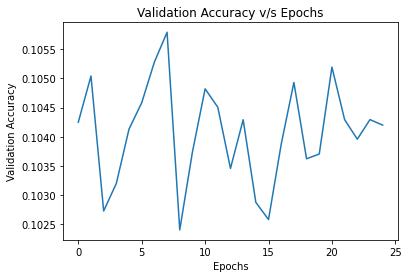

In [ ]:
#Validation Accuracy v/s Epochs
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

**Validation Loss v/s Epochs**

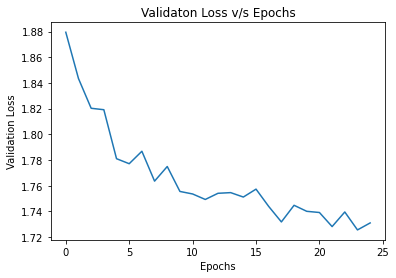

In [ ]:
#Validation Loss v/s Epochs
plt.plot(history.history['val_loss'])
plt.title('Validaton Loss v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()